In [1]:
import random
ALL_RND_SEED = 1
random.seed(ALL_RND_SEED)

import numpy as np

np.random.seed(ALL_RND_SEED)


import tensorflow as tf 

tf.random.set_seed(ALL_RND_SEED)

In [2]:
!pwd

/auto//cwq4yszdy4zhbfkb//curiosity2D_retest_withoutBoost_2/curiositysamp_10b_01


In [2]:
from curiositysampling.ray import OpenMMManager
from curiositysampling.core import CuriousSampling
import ray
from simtk.openmm.app import *
from simtk.openmm import *
import simtk.openmm
from simtk.unit import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
"""Propagating 2D dynamics on the 2D N-well potential using OpenMM.
Currently, ana harmonic restraint on the z coordinate is put,
since OpenMM needs to work in 3D. This isn't really a big deal, except
that it affects the meaning of the temperature and kinetic energy. So
take the meaning of those numbers with a grain of salt.
Based on the gist of David de Sancho: 
https://gist.github.com/daviddesancho/94c2a32f12f897fb68536f723c783a0b#file-openmuller-py
"""

class TwoDTwoWell(CustomExternalForce):
    """OpenMM custom force for propagation on the 2D N-well Potential. Also
    includes pure python evaluation of the potential energy surface so that
    you can do some plotting"""
    
    # You can set the number of wells here
    wells = 4
    # separator of wells in nm
    sep = 2
    # barrier
    barrier = 16
    # local minimum of well
    minimum = -16
    corr = 0.95
    
    def __init__(self):
        # start with a harmonic restraint on the Z coordinate
        potential = ''
        negative_wells = self.wells % 2 + self.wells//2 if self.wells % 2 else self.wells//2
        positive_wells = self.wells - negative_wells
        # start from r=1 and propagate -1, -1 + sep, -1 + 2sep etc ...
        r = 0
        for i in range(negative_wells):
            # add separator
            r_sep = r + self.sep
            bell_neg_1 = '{0} * exp(-(x-{1})^2-(-y-{1})^2)'.format(self.minimum, r)
            bell_neg_2 = '{0} * exp(-(x-{1})^2-(-y-{1})^2)'.format(self.minimum, r_sep)
            barrier_neg = '{0} * exp(-0.08/(2-2 * {1}^2) * (((x-({2})/2)^2+(-y-({2})/2)^2 + 2 * {1} * (x-({2})/2) * (-y-({2})/2))))'.format(self.barrier, self.corr, r_sep+r)
            value_neg =  bell_neg_1 + ' + ' + bell_neg_2 + ' + ' + barrier_neg
            potential += value_neg + ' + '
            # update r with new values, separated by self.sep
            r = r_sep + self.sep
        r = 0
        for i in range(positive_wells):
            # add separator
            r_sep = r + self.sep
            # bell_plus_1 = cls.minimum*np.exp(-(x+r)**2-(y+r)**2)
            # bell_plus_2 = cls.minimum*np.exp(-(x+(r_sep))**2-(y+(r_sep))**2)
            # barrier_plus = cls.barrier*np.exp(-0.08/(2-2*corr**2)*(((x+(r_sep+r)/2)**2+(y+(r_sep+r)/2)**2 + 2*corr*(x+(r_sep+r)/2)*(y+(r_sep+r)/2))))
            bell_plus_1 = '{0} * exp(-(x+{1})^2-(y+{1})^2)'.format(self.minimum, r)
            bell_plus_2 = '{0} * exp(-(x+{1})^2-(y+{1})^2)'.format(self.minimum, r_sep)
            barrier_plus = '{0} * exp(-0.08/(2-2 * {1}^2)*(((x+({2})/2)^2+(y+({2})/2)^2 + 2 * {1} * (x+({2})/2) * (y+({2})/2))))'.format(self.barrier, self.corr, r_sep+r)
            value_neg =  bell_plus_1 + ' + ' + bell_plus_2 + ' + ' + barrier_plus
            potential += value_neg + ' + '
            # update r with new values, separated by self.sep
            r = r_sep + self.sep
        # cls.barrier*((x)+(y))/(cls.wells+cls.sep)**2
        barrier_add = '{0}*((x)+(y))/({1})^2'.format(self.barrier, self.wells+self.sep)
        potential += barrier_add + ' + '
        # add eliptic bound outside the wells
        # outer_bound_term = cls.barrier*((x/(cls.wells*cls.sep))**24+(y/(cls.wells*cls.sep))**24)
        outer_bound_term = '{0}*((x/{1})^24+(y/{1})^24)'.format(self.barrier, self.wells*self.sep)
        potential += outer_bound_term + ' + '
        z_pot = '1000.0 * z^2'
        potential += z_pot
        super(TwoDTwoWell, self).__init__(potential)
    
    @classmethod
    def potential(cls, x, y):
        corr = cls.corr
        "Compute the potential at a given point x,y"
        potential = 0
        negative_wells = cls.wells % 2 + cls.wells//2 if cls.wells % 2 else cls.wells//2
        positive_wells = cls.wells - negative_wells
        # start from r=1 and propagate -1, -1 + sep, -1 + 2sep etc ...
        r = 0
        for i in range(negative_wells):
            # add separator
            r_sep = r + cls.sep
            bell_neg_1 = cls.minimum*np.exp(-(x-r)**2-(-y-r)**2)
            bell_neg_2 = cls.minimum*np.exp(-(x-(r_sep))**2-(-y-(r_sep))**2)
            barrier_neg = cls.barrier*np.exp(-0.08/(2-2*corr**2)*(((x-(r_sep+r)/2)**2+(-y-(r_sep+r)/2)**2 + 2*corr*(x-(r_sep+r)/2)*(-y-(r_sep+r)/2))))
            barrier_add = 0
            value_neg =  bell_neg_1 + bell_neg_2 + barrier_neg + barrier_add
            potential += value_neg
            # update r with new values, separated by cls.sep
            r = r_sep + cls.sep
        r = 0
        for i in range(positive_wells):
            # add separator
            r_sep = r + cls.sep
            bell_plus_1 = cls.minimum*np.exp(-(x+r)**2-(y+r)**2)
            bell_plus_2 = cls.minimum*np.exp(-(x+(r_sep))**2-(y+(r_sep))**2)
            barrier_plus = cls.barrier*np.exp(-0.08/(2-2*corr**2)*(((x+(r_sep+r)/2)**2+(y+(r_sep+r)/2)**2 + 2*corr*(x+(r_sep+r)/2)*(y+(r_sep+r)/2))))
            #barrier_add = (cls.barrier/2)*((x-(r_sep+r)/2)+(y-(r_sep+r)/2))/(cls.wells+cls.sep)**2 
            barrier_add = 0
            value_neg =  bell_plus_1 + bell_plus_2 + barrier_plus + barrier_add
            potential += value_neg
            # update r with new values, separated by cls.sep
            r = r_sep + cls.sep
        barrier_add = cls.barrier*((x)+(y))/(cls.wells+cls.sep)**2
        potential += barrier_add
        # add eliptic bound outside the wells
        outer_bound_term = cls.barrier*((x/(cls.wells*cls.sep))**24+(y/(cls.wells*cls.sep))**24)

        potential += outer_bound_term
        return potential
    # you have to adjust the printing, otherwise it won't print all minima
    @classmethod
    def plot(cls, ax=None, minx=-8, maxx=8, miny=-8, maxy=8, **kwargs):
        "Plot the 2D 2-well potential"
        grid_res = 1000
        grid_width = max(maxx-minx, maxy-miny) / grid_res
        ax = kwargs.pop('ax', None)
        xx, yy = np.mgrid[minx : maxx : grid_width, miny : maxy : grid_width]
        V = cls.potential(xx, yy)
        # clip off any values greater than grid_res, since they mess up
        # the color scheme
        if ax is None:
            # it requires plt object from matplotlib so import accordingly 
            ax = plt
        f = ax.contourf(xx, yy, V, 15, nchunk=3,**kwargs)
        plt.colorbar(f)




In [4]:
# each particle is totally independent, propagating under the same potential
nParticles = 1
mass = 1000 * amu
temperature = 300 * kelvin
friction = 10 / picosecond
timestep = 5.0 * femtosecond


# Choose starting conformations uniform on the grid so that it's r=1 away from the center of the 2D potential
# so we change r_base to e.g. 5 if we want to change r from 1 to 5
startingPositions = Quantity((np.random.rand(nParticles, 3) * np.array([0, 0, 0])) + np.array([-6, -6, 0]), nanometer)
positions = startingPositions

In [5]:
# define 2D twowell potential
twodtwowellforce = TwoDTwoWell()

system = System()
topology = simtk.openmm.app.topology.Topology()
chain = topology.addChain("A")
res = topology.addResidue("1", chain)
# We add mass of the particle later, Hydrogen is used only as a technical trick here
# The hydrogen does not interact with other particles
# Because nonbonded forces are not added to the system
element = simtk.openmm.app.element.Element.getBySymbol('H')
twodtwowellforce = TwoDTwoWell()

for i in range(nParticles):
    # Add particles of mass `mass` to the simulation
    ind = system.addParticle(mass)
    # Add the particle to the defined 2D potential
    twodtwowellforce.addParticle(ind, [])
    # Create topology for the molecules
    topology.addAtom('X'+str(i), element, res, ind)
system.addForce(twodtwowellforce)


integrator = LangevinMiddleIntegrator(temperature, friction, timestep)
#set random seed
integrator.setRandomNumberSeed(ALL_RND_SEED)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(startingPositions)
simulation.context.setVelocitiesToTemperature(temperature)


#save pdb file to cur dir
from simtk.openmm.app import PDBFile, PDBxFile
filehandle = open('positions.pdb', 'w')
PDBFile.writeHeader(topology, filehandle)
PDBFile.writeModel(topology, positions, filehandle, 0)
PDBFile.writeFooter(topology, filehandle)
filehandle.close()

# num of cpus on your computer, if you use cuda=True, you have to specify num_of_gpus=1 also
ray.init(num_cpus=3)
# 40 ps, dt = 0.004 ns
omm = OpenMMManager.remote(positions=positions, system=system, topology=topology,
                           integrator=integrator, steps=1000000, reporter_stride=1000, file_per_cycle=False,
                           warmup_cycles=0, warmup_steps=1000000, warmup_reporter_stride=1000, regular_md=False,
                           cuda=False, selection="all", saving_frequency=1000, use_positions=True, boosting=False, 
                           boosting_amd=False, cpus_per_agent=3) # if you use gpu, cuda=True

In [6]:
config_rnd = {'model': {'target':{'dense_units': [3, 4, 4],
                                 'dense_activ': 'mish',
                                 'dense_layernorm': False,
                                 'dense_batchnorm': False,
                                 'input_batchnorm': False,
                                 'batchnorm_for_cur': False,
                                 'dense_out': 2,
                                 'dense_out_activ': 'linear',
                                 'layernorm_out': False,
                                 'initializer': 'lecun_normal',
                                 'spectral': False,
                                 'orthonormal': False,
                                 'l1_reg': 0.0001,
                                 'l1_reg_activ': 0.0000,
                                 'l2_reg': 0.0001,
                                 'l2_reg_activ': 0.0000,
                                 'unit_constraint': False,
                                 'cnn': True,
                                 'strides': [1, 1, 1],
                                 'kernel_size': [1, 1, 1],
                                 'padding': 'valid'},
              'predictor':{'dense_units': [3, 4, 4],
                                 'dense_activ': 'mish',
                                 'dense_layernorm': False,
                                 'dense_batchnorm': False,
                                 'batchnorm_for_cur': False,
                                 'dense_out': 2,
                                 'dense_out_activ': 'linear',
                                 'layernorm_out': False,
                                 'initializer': 'lecun_normal',
                                 'spectral': False,
                                 'orthonormal': False,
                                 'l1_reg': 0.0001,
                                 'l1_reg_activ': 0.0000,
                                 'l2_reg': 0.0001,
                                 'l2_reg_activ': 0.0000,
                                 'unit_constraint': False,
                                 'cnn': True,
                                 'strides': [1, 1, 1],
                                 'kernel_size': [1, 1, 1],
                                 'padding': 'valid'}},
              'vampnet': True,
              'nonrev_srv': False,
              'reversible_vampnet': False,
              'autoencoder': True,
              'mae': False,
              'autoencoder_lagtime': 100,
              'minibatch_size_cur': 200,
              'minibatch_size_ae': 4000,
              'clip_by_global_norm': False,
              'num_of_train_updates': 500,
              'num_of_ae_train_updates': 500,
              'learning_rate_cur': 0.001,
              'learning_rate_ae': 0.01,
              'clr': False,
              'obs_stand': False,
              'reward_stand': False,
              'train_buffer_size': 1000000,
              'optimizer': 'adab',
              'optimizer_ae': 'adab',
              'target_network_update_freq': 1,
              'hard_momentum': True,
              'vamp2_metric': True,
              'slowp_vector': [1.0, 1.0],
              'classic_loss':  False,
              'whiten': False,
              'logtrans': False,
              'shrinkage': 0.0,
              'energy_mode': None,
              'energy_continuous_constant': 25,
              'slowp_kinetic_like_scaling': False, 
              'timescale_mode_target_network_update': False,
              'protein_cnn': True,
              }
config_env = {'openmmmanager': omm}

In [7]:
# run the simulation for 5 cycles
num_of_cycles = 200
csm = CuriousSampling(rnd_config=config_rnd, env_config=config_env,
                      number_of_agents=1, random_actions=False,
                      buffer_size=20, diskcache=True, working_directory=os.getcwd())
sim_id = csm.get_sim_ids()[0]
intrinsic_reward_reporter = []
action_reporter = []
state_mean_var_reporter = []
reward_var_reporter = []
csm.run(num_of_cycles)


2023-01-19 19:36:08.378624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/include/yaml.h:/usr/lib64/libyaml.so:/usr/include/yaml.h:/usr/lib64/libyaml.so:/home//cwq4yszdy4zhbfkb/.local/miniconda3_/envs/openmm3/lib/:/home//cwq4yszdy4zhbfkb/.local/miniconda3_/envs/openmm3/pkgs/cuda-toolkit/lib/
2023-01-19 19:36:08.378664: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
(pid=17184) Warning: importing 'simtk.openmm' is deprecated.  Import 'openmm' instead.
(pid=17183) Warning: importing 'simtk.openmm' is deprecated.  Import 'openmm' instead.


Use default set positions for every agent/walker
(SingleBiasedSim pid=17183) Trajectory is going to be saved from now
Remove last cycle is False
slowp_kinetic_like_scaling is False
Optimzer is adab
AE Optimzer is adab
Mini-batch size is 4000 for AE/VAMPnet
Mini-batch size is 200 for Curiosity
Cycle 1 out of 200 cycles
Current buffer size 0
Lagged AE training buffer current size is: 1000
Timescales for this epoch: [395.01105  67.16442] ps 
Curiosity stopped training after 11 iterations
Main training buffer current size is: 1000
Predictor Network loss is 10001.9091796875
max reward: 27981.861328125
Total time: 775.35 s   MD time: 765.67 s   ML train time 9.51 s
Saving checkpoint ...
Cycle 2 out of 200 cycles
Current buffer size 1
Lagged AE training buffer current size is: 2000
Eigenvec:  <tf.Variable 'Variable:0' shape=(6, 2) dtype=float32, numpy=
array([[  -5.9673553, -206.44289  ],
       [  -7.2046413,  156.88414  ],
       [  -4.7203364,  106.71255  ],
       [  -2.0775416, -124.2901

In [8]:
import mdtraj as md
import numpy as np
import glob
import os

In [9]:
trajfile = configfiles = glob.glob('**/traj.dcd')
trajfile.sort(key=os.path.getmtime)
traj = md.load(trajfile[-1], top = md.Topology.from_openmm(topology))

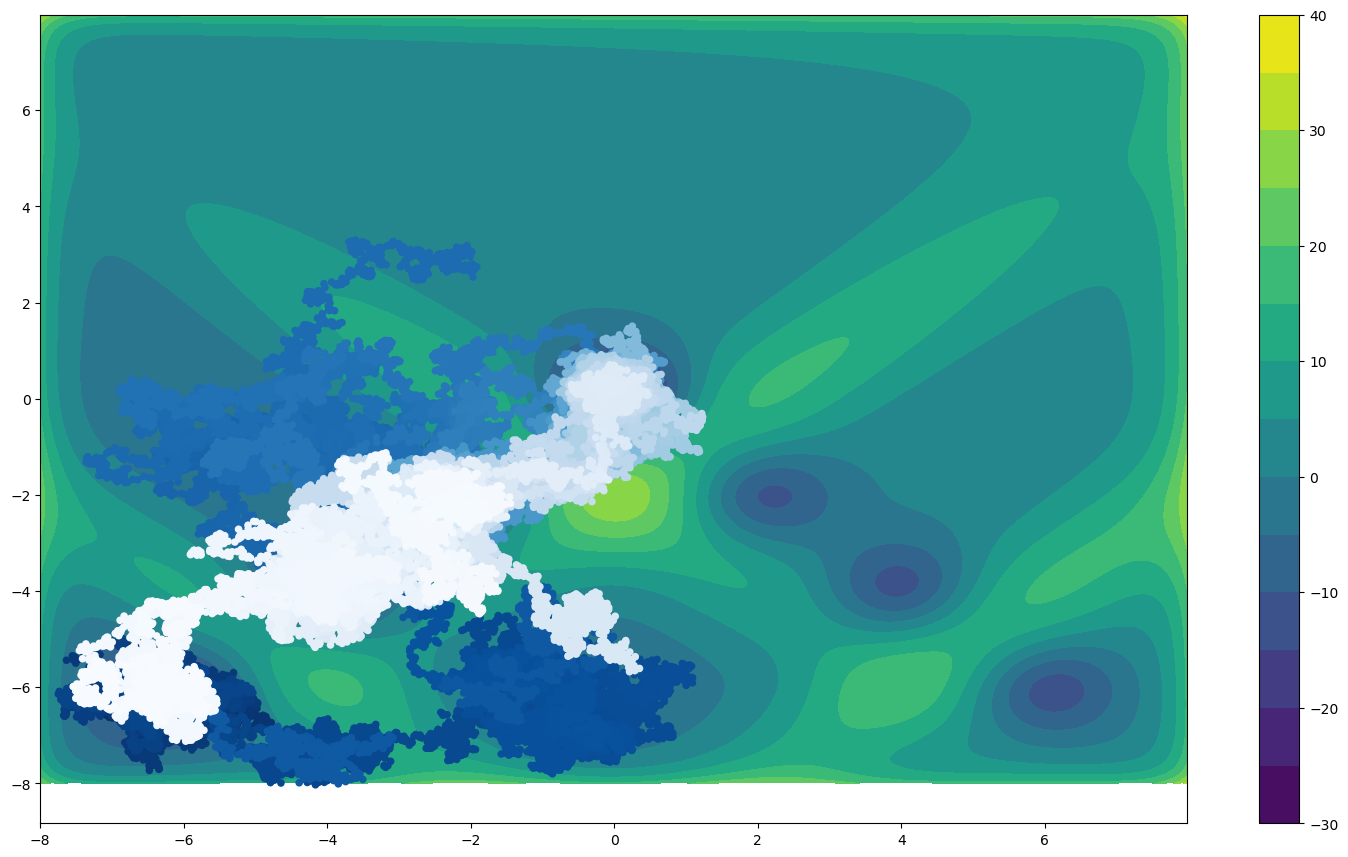

In [10]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
TwoDTwoWell.plot(ax=fig)
color_map = plt.cm.get_cmap('Blues')
norm = traj.xyz.shape[0]
colors = [i/norm for i in range(norm)]
reversed_color_map = color_map.reversed()


xyz = np.squeeze(traj.xyz)
ax = plt.scatter(xyz[:,0], xyz[:,1], c=colors, cmap=reversed_color_map, edgecolor='none', facecolor='k', s=30)
plt.savefig('2Dtwowell_allmd_VAMPrev_norm.png')
plt.show()

df = pd.DataFrame(xyz, columns=["x", "y", "z"])
df.to_csv("trajectory_1.csv")

In [11]:
trajfile = configfiles = glob.glob('**/actionpostions.dcd')
trajfile.sort(key=os.path.getmtime)
traj = md.load(trajfile[-1], top = md.Topology.from_openmm(topology))

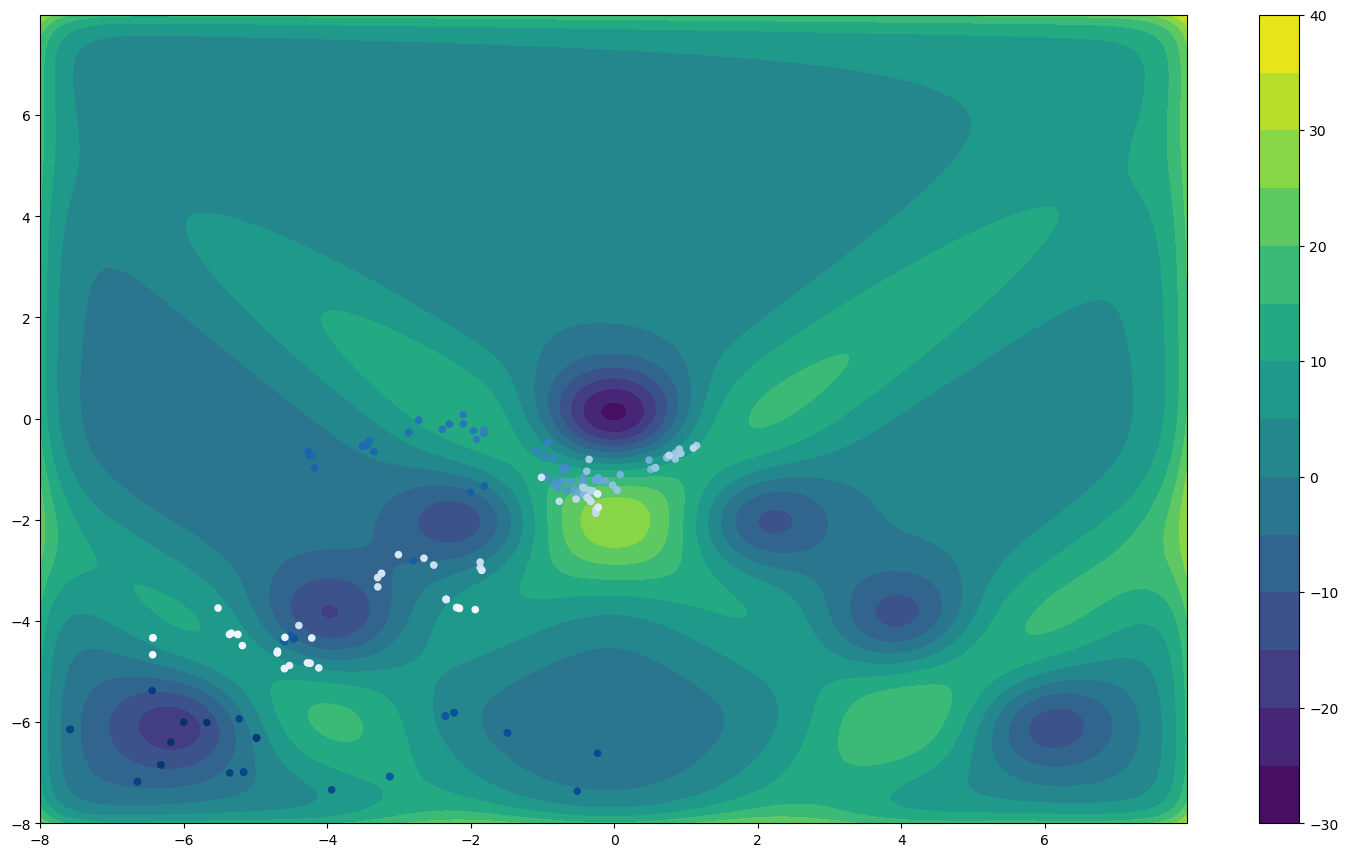

In [12]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
TwoDTwoWell.plot(ax=fig)
color_map = plt.cm.get_cmap('Blues')
norm = traj.xyz.shape[0]
colors = [i/norm for i in range(norm)]
reversed_color_map = color_map.reversed()
xyz = np.squeeze(traj.xyz)

ax = plt.scatter(xyz[:,0], xyz[:,1], c=colors, cmap=reversed_color_map, edgecolor='none', facecolor='k', s=30)
plt.savefig('2Dtwowell_actions_VAMPrev_norm.png', dpi=300)
plt.show()


df = pd.DataFrame(xyz, columns=["x", "y", "z"])
df.to_csv("actions_1.csv")

In [11]:
xyz.shape

(218, 3)

In [ ]:
# plot reward
plt.plot(intrinsic_reward_reporter)

Text(0, 0.5, 'Impl. timescale')

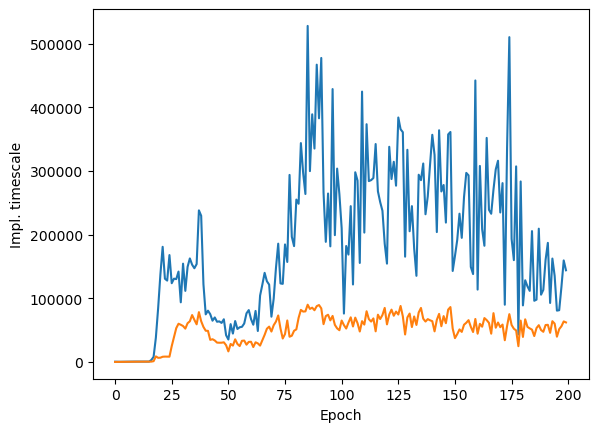

In [13]:
implt = np.nan_to_num(csm.rnd_train_instance.get_implied_time_scales())
implt[implt == 0] = -150
plt.plot(implt)
plt.xlabel('Epoch')
plt.ylabel('Impl. timescale')